In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader , Dataset


# shape = (res + 2pad - kernel) / stride + 1
# (Input Height - 1) × stride + kernel_size - 2 × padding


class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):
        super().__init__()

        self.enc1 = ConvBlock(in_channels, 64)
        self.enc2 = ConvBlock(64, 128)
        self.enc3 = ConvBlock(128, 256)
        self.enc4 = ConvBlock(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = ConvBlock(512, 1024)

    
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = ConvBlock(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = ConvBlock(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(128, 64)

        self.out = nn.Conv2d(64, num_classes, kernel_size=1)


    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        x4 = self.enc4(self.pool(x3))

        # Bottleneck
        x5 = self.bottleneck(self.pool(x4))

        # Decoder
        x = self.up4(x5)
        x = torch.cat([x, x4], dim=1)
        x = self.dec4(x)

        x = self.up3(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec3(x)

        x = self.up2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec2(x)

        x = self.up1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec1(x)

        return self.out(x)
    

pipe = UNet()

In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR


class Data(Dataset):
    def __init__(self, img_dir, mask_dir, img_size=128):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        
        self.images = [f for f in os.listdir(img_dir) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        self.img_transform = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
            T.Normalize([0.667, 0.529, 0.573], [0.164, 0.179, 0.178])
        ])
        
        self.mask_transform = T.Compose([
            T.Resize((img_size, img_size), 
                    interpolation=T.InterpolationMode.NEAREST),  
            T.ToTensor()
        ])
    
    def __len__(self): 
        return len(self.images)
    
    def __getitem__(self, index):
        img_name = self.images[index]
        
    
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        image = self.img_transform(image)
        
        base_name = "".join(img_name.split(".")[0]) 
        
        mask_name = f"{base_name}_Segmentation.png"
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        if not os.path.exists(mask_path):
            mask_path = os.path.join(self.mask_dir, mask_name)
        
        if os.path.exists(mask_path):
            mask = Image.open(mask_path).convert('L')  
        else:
            print(f"Warning: Mask not found for {img_name}")
            mask = Image.new('L', (572, 572), 0)
        
        mask = self.mask_transform(mask)
        mask = (mask > 0.5).float()
        
        return image, mask

In [3]:
train = Data(mask_dir = r"C:\Users\sharm\Downloads\dell\archive\focused\unet\ISBI2016_ISIC_Part1_Training_GroundTruth\ISBI2016_ISIC_Part1_Training_GroundTruth" , img_dir = r"C:\Users\sharm\Downloads\dell\archive\focused\unet\ISBI2016_ISIC_Part1_Training_Data\ISBI2016_ISIC_Part1_Training_Data")
trainLoader = DataLoader(train , shuffle = True , batch_size = 1)

In [4]:
test = Data(img_dir = r"C:\Users\sharm\Downloads\dell\archive\focused\unet\ISBI2016_ISIC_Part1_Test_Data\ISBI2016_ISIC_Part1_Test_Data" , mask_dir = r"C:\Users\sharm\Downloads\dell\archive\focused\unet\ISBI2016_ISIC_Part1_Test_GroundTruth\ISBI2016_ISIC_Part1_Test_GroundTruth")
testloader = DataLoader(test , shuffle = True , batch_size = 1)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class DiceFocalLoss(nn.Module):   
    def __init__(self, 
                 alpha=0.25,          # Focal loss alpha (from paper)
                 gamma=2.0,           # Focal loss gamma (from paper)
                 smooth=1e-6,         # Prevents division by zero
                 reduction='mean',    
                 lambda_focal=0.5,    # Weight for focal loss
                 lambda_dice=0.5,     # Weight for dice loss
                 from_logits=True,    
                 eps=1e-7):           
        super(DiceFocalLoss, self).__init__()
        
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth
        self.reduction = reduction
        self.lambda_focal = lambda_focal
        self.lambda_dice = lambda_dice
        self.from_logits = from_logits
        self.eps = eps
        
        total = lambda_focal + lambda_dice
        if not torch.isclose(torch.tensor(total), torch.tensor(1.0)):
            print(f"Loss weights sum to {total}, normalizing to 1.0")
            self.lambda_focal = lambda_focal / total
            self.lambda_dice = lambda_dice / total
    
    def forward(self, inputs, targets):
        targets = targets.float()
        
        if self.from_logits:
            if inputs.shape[1] == 1 or len(inputs.shape) == 3:
                inputs = torch.sigmoid(inputs)
            else:
                inputs = torch.softmax(inputs, dim=1)
        
        focal_loss = self._focal_loss(inputs, targets)
        
        dice_loss = self._dice_loss(inputs, targets)
        
        total_loss = self.lambda_focal * focal_loss + self.lambda_dice * dice_loss
        
        return total_loss
    
    def _focal_loss(self, inputs, targets):
        inputs_flat = inputs.reshape(-1)
        targets_flat = targets.reshape(-1)
        
        bce_loss = F.binary_cross_entropy(inputs_flat, targets_flat, reduction='none')
        
        p_t = inputs_flat * targets_flat + (1 - inputs_flat) * (1 - targets_flat)
        
        alpha_factor = targets_flat * self.alpha + (1 - targets_flat) * (1 - self.alpha)
        
        modulating_factor = (1.0 - p_t) ** self.gamma
        
        focal_loss = alpha_factor * modulating_factor * bce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss
    
    def _dice_loss(self, inputs, targets):
        inputs_flat = inputs.reshape(inputs.shape[0], -1)
        targets_flat = targets.reshape(targets.shape[0], -1)
        
        intersection = (inputs_flat * targets_flat).sum(dim=1)
        union = inputs_flat.sum(dim=1) + targets_flat.sum(dim=1)
        
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        
        dice_loss = 1. - dice
        
        if self.reduction == 'mean':
            return dice_loss.mean()
        elif self.reduction == 'sum':
            return dice_loss.sum()
        else:
            return dice_loss.reshape(inputs.shape[0], *[1]*(len(inputs.shape)-1))
    
    def get_dice_score(self, inputs, targets):
        with torch.no_grad():
            if self.from_logits:
                inputs = torch.sigmoid(inputs) if inputs.shape[1] == 1 else torch.softmax(inputs, dim=1)
            
            inputs_flat = inputs.reshape(inputs.shape[0], -1)
            targets_flat = targets.reshape(targets.shape[0], -1)
            
            intersection = (inputs_flat * targets_flat).sum(dim=1)
            union = inputs_flat.sum(dim=1) + targets_flat.sum(dim=1)
            
            dice = (2. * intersection + self.smooth) / (union + self.smooth)
            
            return dice.mean().item()

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"

optimizer = torch.optim.Adam(pipe.parameters(), lr=0.001)  
scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='min',       
    factor=0.5,     
    patience=3,  
    verbose=True,
    min_lr=1e-6       
)

pipe.to(device=device)
criterion = DiceFocalLoss(alpha=0.5)

running_loss = 0.0
epochs = 50
best_val_loss = float('inf')
max_patience = 30  

for epoch in range(epochs):
    epoch_loss = 0.0
    pipe.train()
    
    for batch_idx, (img, mask) in enumerate(trainLoader):
        img, mask = img.to(device=device), mask.to(device=device)

        output = pipe(img)
        
        if output.shape[-2:] != mask.shape[-2:]:
            mask = F.interpolate(mask, size=output.shape[-2:], mode='nearest')
        
        loss = criterion(output, mask)
        
        optimizer.zero_grad()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(pipe.parameters(), max_norm=1.0)
        
        optimizer.step()
        epoch_loss += loss.item()
        
        if batch_idx % 10 == 0:
            print(f"  Batch {batch_idx}: Loss = {loss.item():.6f}")

    avg_train_loss = epoch_loss / len(trainLoader)
    print(f'\nEpoch {epoch} | Train Loss: {avg_train_loss:.6f}')
    
    val_loss = 0.0
    num_batches = 0
    pipe.eval()
    
    with torch.no_grad():
        for img, mask in testloader:
            img, mask = img.to(device=device), mask.to(device=device)
            output = pipe(img)
            
            if output.shape[-2:] != mask.shape[-2:]:
                mask = F.interpolate(mask, size=output.shape[-2:], mode='nearest')
            
            loss = criterion(output, mask)
            val_loss += loss.item()
            num_batches += 1
    
    avg_val_loss = val_loss / num_batches
    print(f"Validation Loss: {avg_val_loss:.6f}")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        print(f"✓ Best validation loss improved to {best_val_loss:.6f}")
        
    
    
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current Learning Rate: {current_lr}\n")

print(f"Best validation loss: {best_val_loss:.6f}")

  Batch 0: Loss = 0.093824
  Batch 10: Loss = 0.287923
[Debug] Loss components - Focal: 0.0224, Dice: 0.1336, Total: 0.0780
  Batch 20: Loss = 0.070911
  Batch 30: Loss = 0.027608
  Batch 40: Loss = 0.395951
  Batch 50: Loss = 0.094021
  Batch 60: Loss = 0.152568
[Debug] Loss components - Focal: 0.0660, Dice: 0.1539, Total: 0.1100
  Batch 70: Loss = 0.174032
  Batch 80: Loss = 0.088458
  Batch 90: Loss = 0.085111
  Batch 100: Loss = 0.098854
  Batch 110: Loss = 0.223527
  Batch 120: Loss = 0.513567
  Batch 130: Loss = 0.087939
  Batch 140: Loss = 0.092204
[Debug] Loss components - Focal: 0.3225, Dice: 0.7042, Total: 0.5133
  Batch 150: Loss = 0.140505
  Batch 160: Loss = 0.073186
  Batch 170: Loss = 0.106216
  Batch 180: Loss = 0.172787
  Batch 190: Loss = 0.062266
  Batch 200: Loss = 0.059433
  Batch 210: Loss = 0.038778
  Batch 220: Loss = 0.082345
  Batch 230: Loss = 0.098358
  Batch 240: Loss = 0.538864
  Batch 250: Loss = 0.086851
  Batch 260: Loss = 0.096281
  Batch 270: Loss = 0

In [45]:
torch.save(pipe, 'unet_full.pth')

In [5]:
pipe = torch.load("unet_full.pth" , map_location = 'cpu')

C:\Users\sharm\AppData\Local\Temp\ipykernel_24368\3315331128.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pipe = torch.load("unet_full.pth" , map_location = 'cpu')


C:\Users\sharm\AppData\Local\Temp\ipykernel_24368\2444686624.py:36: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray((mask_np * 255).astype(np.uint8), mode='L')


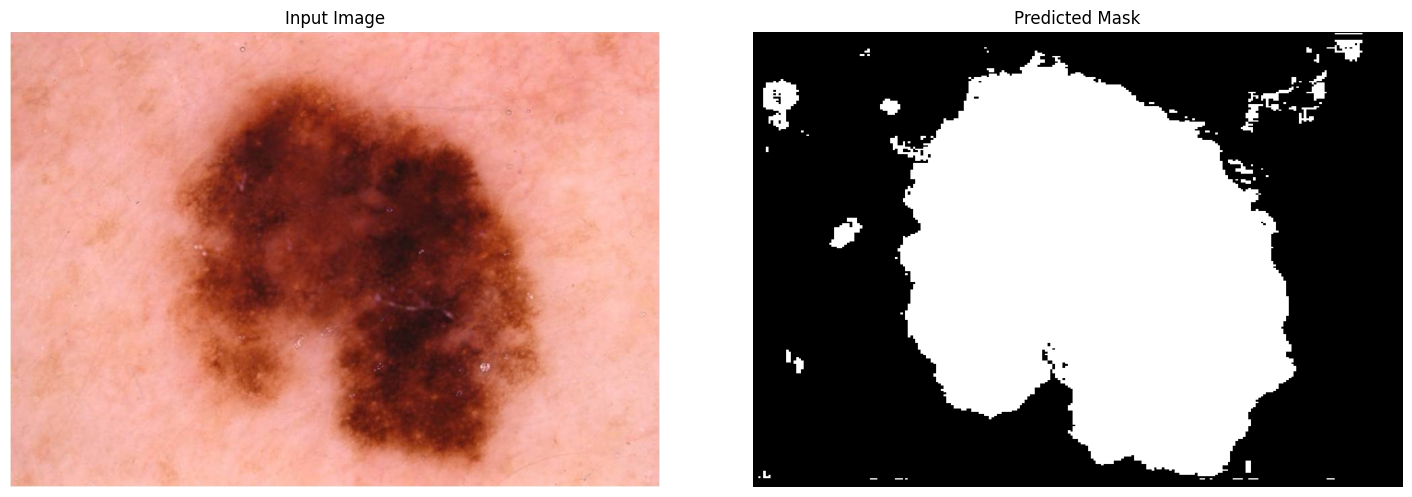

In [ ]:
import torch 
import numpy as np
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
pipe.to(device = device)

def predict_to_image(model, image_path, device='cuda', save_path=None):
   
    from PIL import Image
    import torchvision.transforms as T
    
    input_image = Image.open(image_path).convert('RGB')
    original_size = input_image.size
    
    transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
        T.Normalize(mean=[0.667, 0.529, 0.573], 
                   std=[0.164, 0.179, 0.178])
    ])
    
    image_tensor = transform(input_image).unsqueeze(0).to(device)
    
    
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        pred_tensor = torch.sigmoid(output)
        mask_tensor = (pred_tensor > 0.5).float()
    
    mask_np = mask_tensor.squeeze().cpu().numpy()  # [H, W]
    
    mask_pil = Image.fromarray((mask_np * 255).astype(np.uint8), mode='L')
    
    mask_pil = mask_pil.resize(original_size, Image.NEAREST)
    
    
    return input_image, mask_pil

image_path = r"C:\Users\sharm\Downloads\dell\archive\focused\unet\ISBI2016_ISIC_Part1_Test_Data\ISBI2016_ISIC_Part1_Test_Data\ISIC_0000172.jpg"


input_img, mask_img = predict_to_image(
    pipe, image_path, device=device)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(input_img)
axes[0].set_title('Input Image')
axes[0].axis('off')

axes[1].imshow(mask_img, cmap='gray')
axes[1].set_title('Predicted Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()